In [1]:
import importlib as imp
import spotiphy
import numpy as np
import scanpy as sc
import squidpy as sq
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import spotiphy
import seaborn as sns

In [3]:
# adata_st = sc.read_h5ad("results/Xenium1/adata_st.h5ad")
adata_st = sc.read_h5ad("F:/Ziqian Zheng/Spotiphy_data/Simulated ST/ST_Simulated1.h5ad")
adata_st.uns['spatial']['NCF221-D']['scalefactors']['tissue_hires_crop_scalef'] = 0.2
type_list = adata_st.uns['type_list']
results_folder = 'results/Simulation1/evaluation_spotiphy/'
data_folder = 'results/Simulation1/evaluation_spotiphy/deconvolution/'
type_list_RCTD = [s.replace('/', '') for s in type_list]
type_list_RCTD = [s.replace(' ', '.') for s in type_list_RCTD]

# cell_count_truth = adata_st.obs[type_list].to_numpy()
cell_count_truth = adata_st.obsm['ground_truth']
selected_spot = np.sum(cell_count_truth, axis=1)>0
proportion_truth = cell_count_truth[selected_spot]/np.sum(cell_count_truth[selected_spot], axis=1,
                                                          keepdims=True)

In [6]:
proportion_estimated = []
for i in range(10):
    proportion_estimated += [np.load(data_folder+'proportion'+str(i)+'.npy')[selected_spot]]

methods = [str(i) for i in range(10)]
proportion_estimated = [p for p in proportion_estimated]
proportion_dict = {k:v for k, v in zip(methods, proportion_estimated)}
adata_st = adata_st[selected_spot]

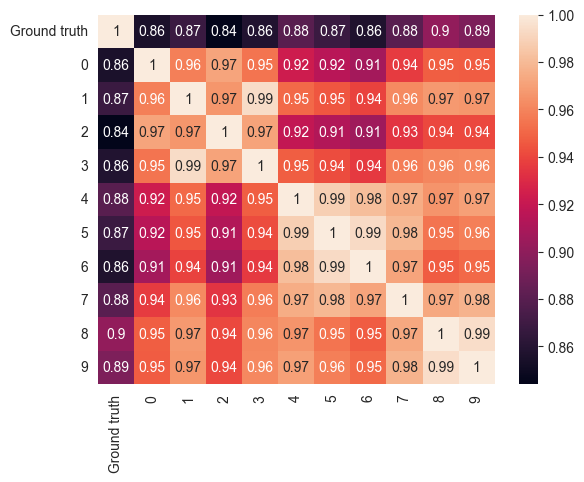

In [7]:
proportion_agg = [proportion_truth.flatten()] + [proportion.flatten() for proportion in proportion_estimated]
proportion_agg = np.vstack(proportion_agg)
corr_matrix = np.corrcoef(proportion_agg)
plt.grid(False)
sns.heatmap(corr_matrix, xticklabels=['Ground truth']+methods, yticklabels=['Ground truth']+methods, annot=True)
plt.savefig(results_folder+'correlation_all', dpi=400, bbox_inches = 'tight')

In [ ]:
Eval = spotiphy.deconvolution.Evaluation(proportion_truth, proportion_estimated, methods, out_dir=results_folder)
metrics = ['Cosine similarity', 'Absolute error', 'Square error', 'Correlation', 'Fraction of cells correctly mapped',
           'JSD']
for metric in metrics:
    Eval.plot_metric(save=True, metric=metric, metric_type='Spot')
    Eval.plot_metric(save=True, metric=metric, metric_type='Cell type')

In [ ]:
for i, cell_type in enumerate(type_list):
    proportion_agg = [proportion_truth[:, i]+1e-8] + [proportion[:, i]+1e-8 for proportion in proportion_estimated]
    proportion_agg = np.vstack(proportion_agg)
    corr_matrix = np.corrcoef(proportion_agg)
    plt.figure(figsize=(7, 6))
    plt.grid(False)
    plt.title(cell_type)
    sns.heatmap(corr_matrix, xticklabels=['Ground truth']+methods, yticklabels=['Ground truth']+methods, annot=True)
    cell_type = "".join(x for x in cell_type if x.isalnum())
    plt.savefig(results_folder+'extra figures/correlation_'+cell_type+'.png', dpi=400, bbox_inches = 'tight')

In [5]:
import importlib as imp
imp.reload(spotiphy.deconvolution)

<module 'spotiphy.deconvolution' from 'C:\\Users\\zzheng92\\Desktop\\Spotiphy\\spotiphy\\deconvolution.py'>

In [ ]:
Eval = spotiphy.deconvolution.Evaluation(proportion_truth, proportion_estimated, methods, out_dir=results_folder,
                                         type_list=type_list)
Eval.plot_metric_spot_type(save=True, metric='Absolute error')

In [ ]:
type_list_truth = [type +'_truth' for type in type_list]
adata_st.obs[type_list_truth] = proportion_truth
type_list_method = []
for method in methods:
    type_list_method.append([type +'_' + method for type in type_list])
    adata_st.obs[type_list_method[-1]] = proportion_dict[method]

In [19]:
%matplotlib agg
%matplotlib agg
vmax = np.quantile(adata_st.obs[type_list_truth].to_numpy(), 0.98, axis=0)
vmax[vmax < 0.05] = 0.05
with mpl.rc_context({'figure.figsize': [4, 4.5], 'figure.dpi': 800}):
    for j, method in enumerate(methods):
        for i, cell_type in enumerate(type_list):
            ax = sc.pl.spatial(adata_st, cmap='magma', color=cell_type+'_'+method, img_key='hires', vmin=0, vmax=vmax[i],
                               size=1.3, show=False)
            cell_type = "".join(x for x in cell_type if x.isalnum())
            ax[0].get_figure().savefig(results_folder+'deconvolution figure/'+method+'/'+cell_type+'.jpg')

In [4]:
celltype_group = [['L2/3 IT CTX', 'L4 IT CTX', 'L5 PT CTX', 'L6 CT CTX', 'CA', 'DG', 'Lamp5', 'Pvalb'],
                  ['Astro', 'Oligo'],
                  ['Microglia'],
                  ['L2/3 IT CTX']]
i = 3
celltype_select = celltype_group[i]
celltype_idx = np.array([list(type_list).index(cell_type) for cell_type in celltype_select])

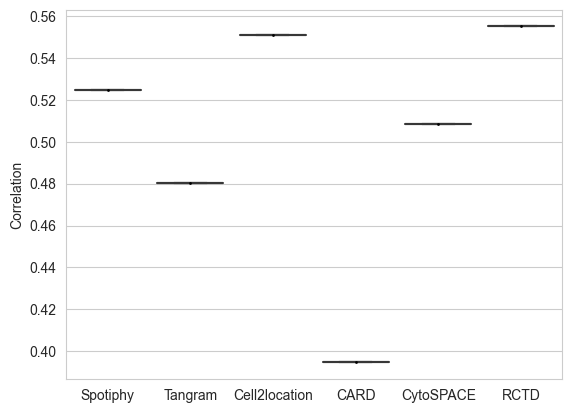

In [5]:
celltype_idx = np.array([5])
Eval = spotiphy.deconvolution.Evaluation(proportion_truth[:, celltype_idx],
                                         [p[:, celltype_idx] for p in proportion_estimated],
                                         methods,
                                         out_dir=results_folder)
Eval.plot_metric_type(save=False, metric='Correlation')

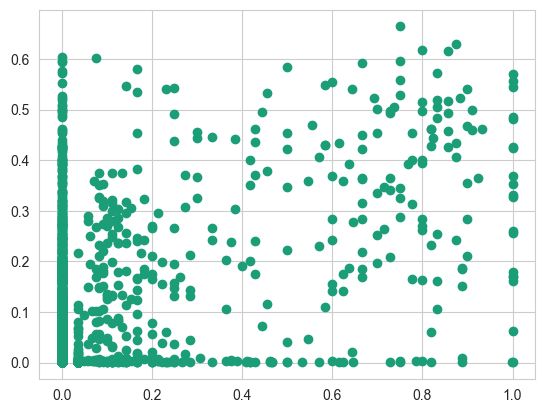

In [6]:
plt.scatter(proportion_truth[:, celltype_idx], proportion_spotiphy[:, celltype_idx])